# Equilibrium Diagram of a Box Beam under Uniaxial Compression

***

In our [previous notebook](10_On_the_Mechanical_Cause_of_the_Box_Beam_Bifurcation_Break.ipynb) we showed that the application of a bending load to a box beam results in an asymmetry of the internal loads about the midplane of the top skin. We consider this to be the cause of the bifurcation break observed for both the [unreinforced](06_Nonlinear_Buckling_Method_Verification.ipynb) and the [reinforced box beam](08_Nonlinear_Buckling_of_a_Reinforced_Box_Beam.ipynb#nonlinear-buckling-method-verification). To prove that the bending load is responsible for the bifurcation break, in this notebook we are going to investigate the equilibrium diagram of the box beam under a uniaxial compression, where we expect to see the bifurcation restored. We are going to investigate this for both the unreinforced and the reinforced box beam configurations.

* [Unreinforced box beam](#unreinforced)
    * [Setup of the numerical model](#unreinforced-numerical-model)
    * [Linear buckling analysis](#unreinforced-linear-buckling)
    * [Nonlinear analysis](#unreinforced-nonlinear-analysis)
* [Reinforced box beam](#reinforced)
    * [Setup of the numerical model](#reinforced-numerical-model)
    * [Linear buckling analysis](#reinforced-linear-buckling)
    * [Nonlinear analysis](#reinforced-nonlinear-analysis)
* [Conclusions](#conclusions)


## Unreinforced box beam <a name="unreinforced"></a>

***

### Setup of the numerical model <a name="unreinforced-numerical-model"></a>

We consider an unreinforced box beam with the same geometry and material properites as in our previous notebooks.

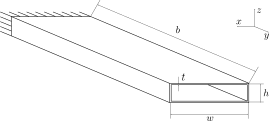

In [361]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces

SVG(filename=os.path.join('resources', '04_BoxBeamGeometry.svg'))

In [362]:
AR = 9.   # aspect ratio - 2*b/w (the span of the box beam corresponds to half the span of the CRM wing)
w = 1e3   # width [mm]
b = AR*w/2  # span [mm]
non_dimensional_height = 0.2  # h/w
h = w*non_dimensional_height  # box height [mm]
non_dimensional_thickness = 1/50  # t/h
t = h*non_dimensional_thickness   # shell thickness [mm]
print(f'Box beam dimensions:\n- width: {w/1e3:.2f} m\n- span: {b/1e3:.2f} m\n- height: {h/1e3:.2f} m\n- wall thickness: {t:.2f} mm')

Box beam dimensions:
- width: 1.00 m
- span: 4.50 m
- height: 0.20 m
- wall thickness: 4.00 mm


In [363]:
rho = 2780e-12  # density [ton/mm^3]
E = 73.1e3  # Young's modulus [MPa]
nu = 0.3  # Poisson's ratio

We create a mesh of quadrilateral elements using the function `mesh_box_with_pyvista` from the `box_beam_utils` module. We prescribe an edge length of 86 mm based on the results of a previous [mesh convergence study](04_Nonlinear_Buckling_Analysis_of_a_Box_Beam.ipynb).

In [364]:
from resources import box_beam_utils

edge_length = 86  # [mm]
unreinforced_box_beam_mesh = box_beam_utils.mesh_box_with_pyvista(width=w, span=b, height=h, edge_length=edge_length)
nodes_coordinates_array = unreinforced_box_beam_mesh.points
nodes_connectivity_matrix = unreinforced_box_beam_mesh.faces.reshape(-1, 5)[:, 1:]

Now we create a base `BDF` object where we define fixed boundary conditions at the root of the box beam.

In [365]:
unreinforced_box_beam_bdf = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)  # create BDF object
print(unreinforced_box_beam_bdf.get_bdf_stats())  # print cards of BDF object

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 1760

bdf.elements: 0
  CQUAD4   : 1728

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


Then we apply a concentrated tip load at the center of the tip section as shown below. We use a RBE2 element to connect the nodes along the tip section to the node in the center.

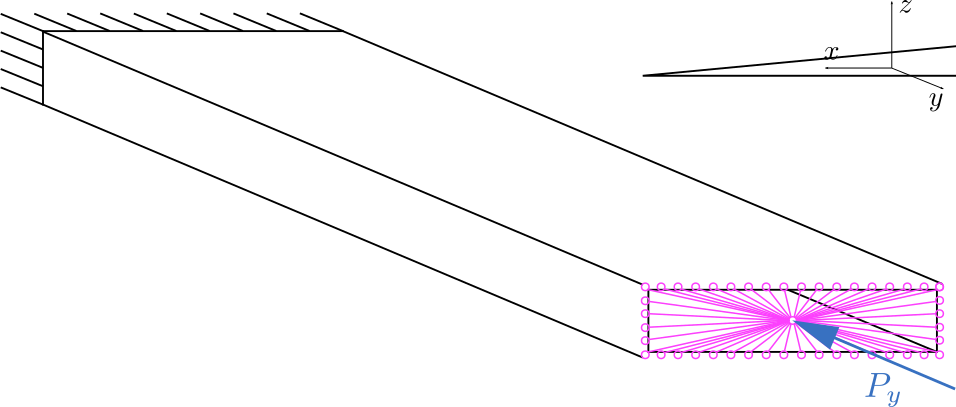

In [366]:
SVG(filename=os.path.join('resources', '11_BoxBeamCompressionLoad.svg'))

In [367]:
import numpy as np
from resources import pynastran_utils

# Find id of tip nodes
nodes_ids = np.arange(1, np.size(nodes_coordinates_array, 0) + 1)
tolerance = edge_length/100
tip_nodes_ids = nodes_ids[np.abs(nodes_coordinates_array[:,1] - b) < tolerance]

# Add master node of tip section
tip_section_master_node_id = np.amax(nodes_ids) + 1
unreinforced_box_beam_bdf.add_grid(tip_section_master_node_id, [w/2, b, 0.])

# Add RBE2 to connect master node with outer nodes of tip rib
rbe2_eid = len(unreinforced_box_beam_bdf.elements) + 1
unreinforced_box_beam_bdf.add_rbe2(eid=rbe2_eid, gn=tip_section_master_node_id, cm='123456', Gmi=tip_nodes_ids)

# Add concentrated force
compression_force_set_id = 11
compression_force_direction = [0., -1., 0.]
pynastran_utils.add_unitary_force(bdf_object=unreinforced_box_beam_bdf, nodes_ids=[tip_section_master_node_id], set_id=compression_force_set_id, direction_vector=compression_force_direction)

### Linear buckling analysis <a name="unreinforced-linear-buckling"></a>

We use SOL 105 to calculate the linear buckling load and the corresponding buckling shape, so that we have a reference for the nonlinear analysis.

Buckling load: 59049 N
Buckling mode:


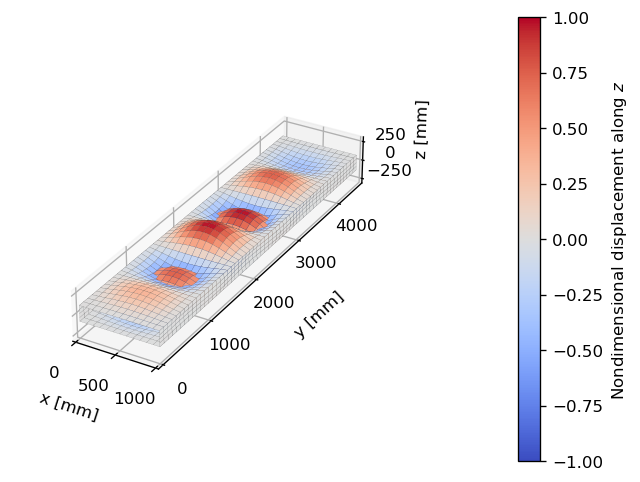

In [368]:
from resources import pynastran_utils
import matplotlib.pyplot as plt

# Run SOL 105 and return OP2 object
analysis_directory_name = '11_Equilibrium_Diagram_of_a_Box_Beam_Under_Uniaxial_Compression'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)
input_name = 'unreinforced_box_beam_linear_buckling'
sol_105_op2 = pynastran_utils.run_sol_105_buckling_analysis(bdf_object=unreinforced_box_beam_bdf.__deepcopy__({}), static_load_set_id=compression_force_set_id, analysis_directory_path=analysis_directory_path, input_name=input_name, run_flag=False)  # we pass a deep copy of the BDF object to the function to be able to set up the nonlinear analysis later

# Define function to adjust axes ticks and labels' position
def set_ticks_and_labels_position(axes):
    axes.locator_params(axis='x', nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis='z', nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis='y', which='major', pad=20)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis='z', which='major', pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 60  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label

# Print critical buckling load and plot mode
sol_105_buckling_load = sol_105_op2.eigenvectors[2].eigr
print(f'Buckling load: {sol_105_buckling_load:.0f} N')
plt.rcParams['figure.dpi'] = 120  # set default dpi of figures
print(f'Buckling mode:')
_, ax = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=2, displacement_component='tz', colormap='coolwarm')
set_ticks_and_labels_position(ax)
plt.show()

We observe that the shape of the first buckling mode predicted by SOL 105 is characterized by six alternating waves over each skin with a top-down symmetry.

### Nonlinear analysis <a name="unreinforced-nonlinear-analysis"></a>

Now we move on to the nonlinear analysis, which will help us to prove the existence of a bifurcation in the equilibrium diagram of the box beam.

We start by setting up our `BDF` object for a nonlinear analysis with the full Newton method. For this we use the function `set_up_newton_method` from the `pynastran_utils` module. This function assigns SOL 106 as solution sequence, adds a NLPARM card with the input parameters and set it as the default nonlinear solver. We also add another NLPARM card and a NLPCI card to define a nonlinear iteration strategy employing the arc-length method. We are going to use the arc-length method only for the first subcase, while for the other subcases we need the Newton method. This is because the arc-length method in Nastran has issues when trying to change the load application direction between successive subcases. All the nonlinear parameters are taken from the results of a [previous sensitivity study](08_Nonlinear_Buckling_of_a_Reinforced_Box_Beam.ipynb#nonlinear-analysis-parameters).

In [369]:
# Set up nonlinear analysis with full Newton method
no_increments = 100
load_tolerance = 1e-3
energy_tolerance = 1e-7
pynastran_utils.set_up_newton_method(bdf_object=unreinforced_box_beam_bdf, ninc=no_increments, eps_p=load_tolerance, eps_w=energy_tolerance)

# Add cards for arc-length method
arclength_nlparm_id = 2
unreinforced_box_beam_bdf.add_nlparm(nlparm_id=arclength_nlparm_id, ninc=no_increments, kmethod='ITER', kstep=1, int_out='YES', eps_p=load_tolerance, eps_w=energy_tolerance)
unreinforced_box_beam_bdf.add_nlpci(nlpci_id=arclength_nlparm_id, Type='CRIS', maxalr=1.1, desiter=5, mxinc=no_increments)

NLPCI          2    CRIS     .25     1.1      0.               5     100

To explore the bifurcation in the equilibrium diagram we need to add an imperfection to our structure. Similarly to the case of the [Euler's column](02_Supercritical_Pitchfork_Bifurcation_of_Euler_Column.ipynb) and of the [thin plate under uniaxial compression](03_Equilibrium_Diagram_of_a_Thin_Plate_under_Uniaxial_Compression.ipynb), we implement the imperfection adding a vertical force at the center of the top skin.

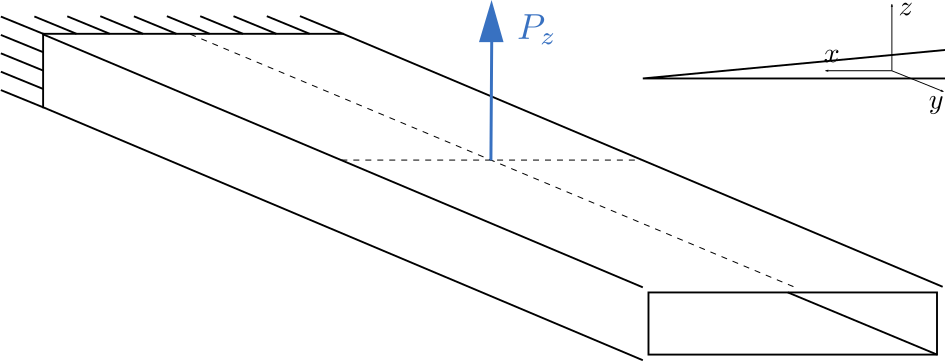

In [370]:
SVG(filename=os.path.join('resources', '11_BoxBeamEccentricLoad.svg'))

In [371]:
# Find id of node at the center of top skin
top_skin_central_node_id = np.argmin(np.apply_along_axis(np.linalg.norm, 1, nodes_coordinates_array - np.array([w/2, b/2, h/2]))) + 1  # calculate distance between nodes and center of the top skin and find index where distance is minimum

# Add FORCE card
vertical_force_set_id = compression_force_set_id + 1  # define set idenfitification number of the FORCE card
vertical_force_direction = [0., 0., 1.]  # define direction of the vertical force
pynastran_utils.add_unitary_force(bdf_object=unreinforced_box_beam_bdf, nodes_ids=[top_skin_central_node_id], set_id=vertical_force_set_id, direction_vector=vertical_force_direction)  # add FORCE card

Now we need to define our subcase sequence. We expect to find three branches departing from the bifurcation point, so our strategy will be to explore one branch at a time.

1. In the first subcase we explore branch corresponding to the zero-deflection branch of Euler's column. For this reason we apply only the compression load $P_y$ with a magnitude $P_y/P_{\text{SOL 105}}=1.5$, where $P_{\text{SOL 105}}$ is the buckling load predicted by SOL 105.
2. In subcase 2 we unload the structure.
3. Since we cannot directly explore the other branches, we use the third subcase as an intermediate step by applying a combined compression and vertical load, with $P_y/P_{\text{SOL 105}}=1.5$ and $P_z/P_{\text{SOL 105}}=1/100$.
4. In the fourth subcase we remove the vertical load and we leave only the compression load. We expect this to result in a different deformation state with respect to the one resulting from subcase 1.
5. In subcase 5 we completely unload the structure, in order to walk the equilibrium path "backwards" to the critical point and then to the undeformed state of the structure.
6. Similarly to subcase 3, the sixth subcase is an intermediate step to explore the other branch of the bifurcation. We apply the same load combination of subcase 3, but with the vertical load in the opposite direction.
7. In subcase 7 we remove the vertical load and we expect to find the opposite displacement state found at the end of subcase 4, so with inverted upwards-downwards displacements.
8. In the eighth and last subcase we completely unload the structure to visualize the equilibrium path of the bifurcation branch.


In [372]:
# Subcase 1
compression_load_set_id = 21  # define set identification number of LOAD card
compression_load_magnitude = sol_105_buckling_load*1.5
unreinforced_box_beam_bdf.add_load(sid=compression_load_set_id, scale=1., scale_factors=[compression_load_magnitude], load_ids=[compression_force_set_id])
subcase_id = 1
pynastran_utils.create_static_load_subcase(bdf_object=unreinforced_box_beam_bdf, subcase_id=subcase_id, load_set_id=compression_load_set_id)
unreinforced_box_beam_bdf.case_control_deck.subcases[subcase_id].add_integer_type('NLPARM', arclength_nlparm_id)  # define NLPARM card to use for this subcase

# Subcase 2
zero_load_set_id = compression_load_set_id + 1
unreinforced_box_beam_bdf.add_load(sid=zero_load_set_id, scale=1., scale_factors=[0.], load_ids=[compression_force_set_id])
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(bdf_object=unreinforced_box_beam_bdf, subcase_id=subcase_id, load_set_id=zero_load_set_id)

# Subcase 3
eccentric_compression_load_set_id = zero_load_set_id + 1
vertical_load_magnitude = sol_105_buckling_load/100
unreinforced_box_beam_bdf.add_load(sid=eccentric_compression_load_set_id, scale=1., scale_factors=[compression_load_magnitude, vertical_load_magnitude], load_ids=[compression_force_set_id, vertical_force_set_id])
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(bdf_object=unreinforced_box_beam_bdf, subcase_id=subcase_id, load_set_id=eccentric_compression_load_set_id)

# Subcase 4
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(bdf_object=unreinforced_box_beam_bdf, subcase_id=subcase_id, load_set_id=compression_load_set_id)

# Subcase 5
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(bdf_object=unreinforced_box_beam_bdf, subcase_id=subcase_id, load_set_id=zero_load_set_id)

# Subcase 6
opposite_eccentric_compression_load_set_id = eccentric_compression_load_set_id + 1
unreinforced_box_beam_bdf.add_load(sid=opposite_eccentric_compression_load_set_id, scale=1., scale_factors=[compression_load_magnitude, -1*vertical_load_magnitude], load_ids=[compression_force_set_id, vertical_force_set_id])
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(bdf_object=unreinforced_box_beam_bdf, subcase_id=subcase_id, load_set_id=opposite_eccentric_compression_load_set_id)

# Subcase 7
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(bdf_object=unreinforced_box_beam_bdf, subcase_id=subcase_id, load_set_id=compression_load_set_id)

# Subcase 8
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(bdf_object=unreinforced_box_beam_bdf, subcase_id=subcase_id, load_set_id=zero_load_set_id)

Let's run the analysis and let's plot the deformation of our box beam at the end of each subcase.

Nastran job unreinforced_box_beam_nonlinear_analysis.bdf completed
Wall time: 446.0 s


Subcase 1


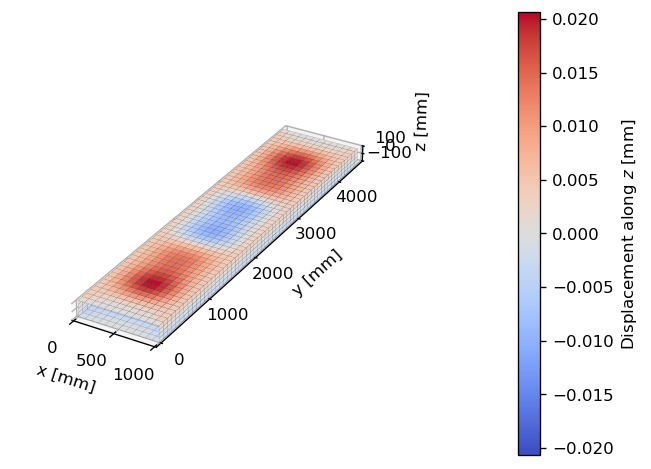

Subcase 2


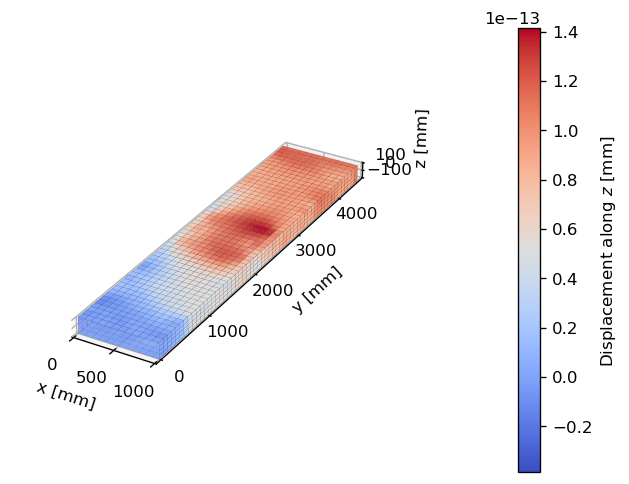

Subcase 3


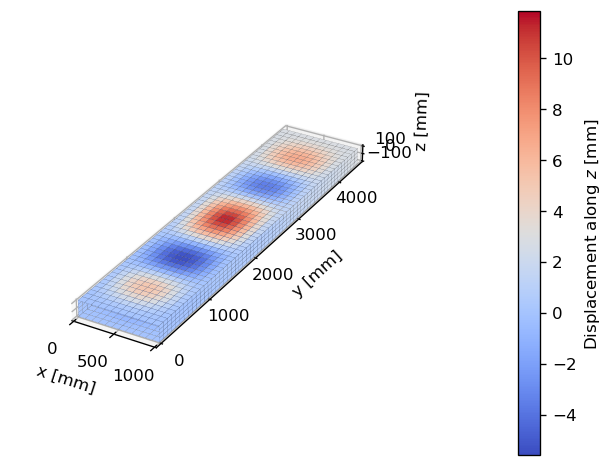

Subcase 4


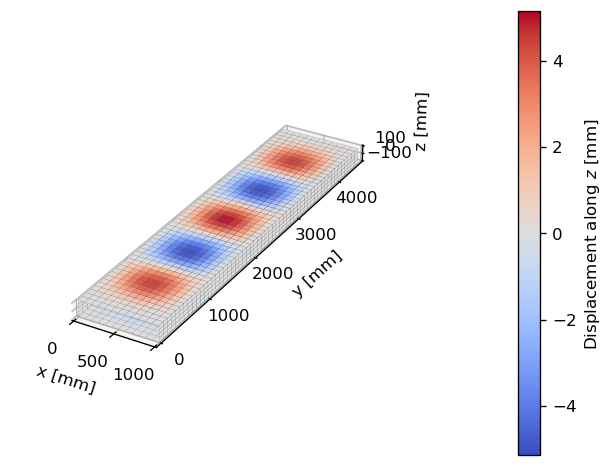

Subcase 5


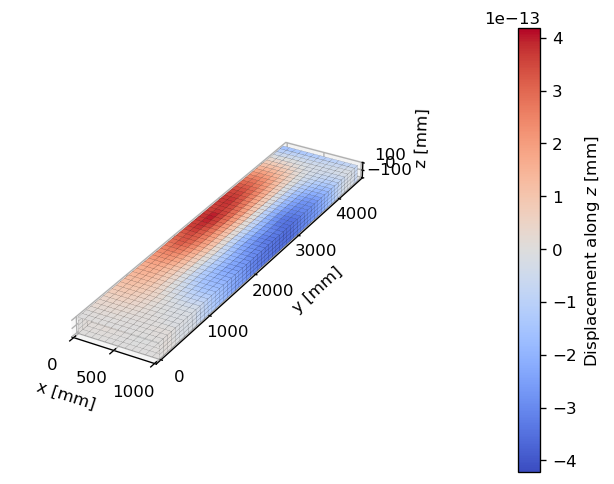

Subcase 6


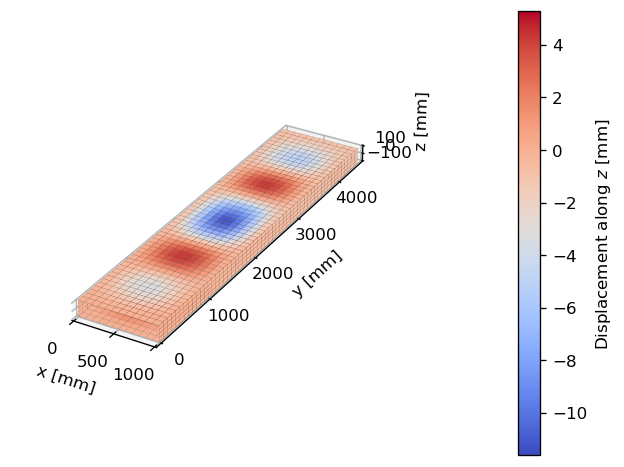

Subcase 7


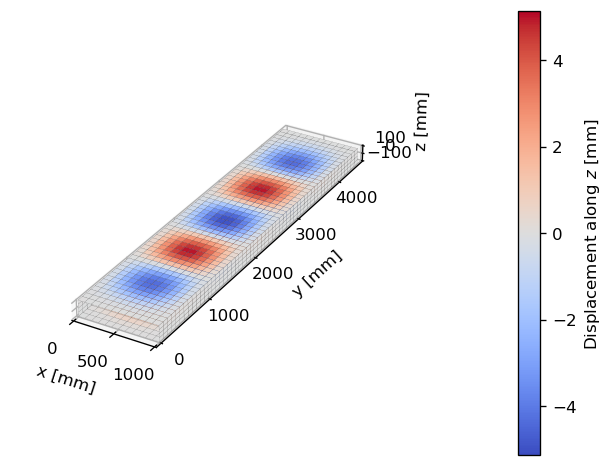

Subcase 8


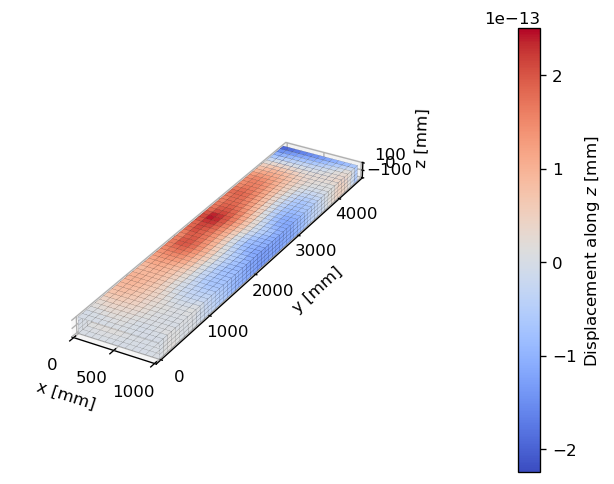

In [373]:
from pyNastran.op2.op2 import read_op2

# Run analysis
input_name = 'unreinforced_box_beam_nonlinear_analysis'
pynastran_utils.run_analysis(bdf_object=unreinforced_box_beam_bdf, directory_path=analysis_directory_path, filename=input_name, run_flag=False)

# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
sol_106_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)

# Plot deformation
for i in range(1, subcase_id + 1):  # iterate through subcases
    print(f'\033[1mSubcase {i:.0f}')
    _, ax = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2, subcase_id=i, displacement_component='tz', colormap='coolwarm')  # plot final deformation
    set_ticks_and_labels_position(ax)
    plt.show()

The displacement field obtained at the end of subcases 1, 4 and 7 is different, suggesting that there should be a bifurcation in the equilibrium diagram of our box beam. Furthermore, the displacement field at the end of subcases 4 and 7 appears to be equal and opposite, as we were expecting given our loading sequence.

Now We want to visualize the equilibrium diagram in terms of $P_y/P_{\text{SOL 105}}$, $P_z/P_{\text{SOL 105}}$ and the displacement along $z$ of a given node of the top skin. We choose to monitor the vertical displacement at a node that is approximately at the center of the first blob observed for subcases 4 and 7 looking from the root of the box beam ($y\approx640$ mm). Similarly to our investigation on [Euler's column](02_Supercritical_Pitchfork_Bifurcation_of_Euler_Column.ipynb) and on the [thin plate under uniaxial compression](03_Equilibrium_Diagram_of_a_Thin_Plate_under_Uniaxial_Compression.ipynb), we visualize the equilibrium diagram with both 2D and 3D plots.

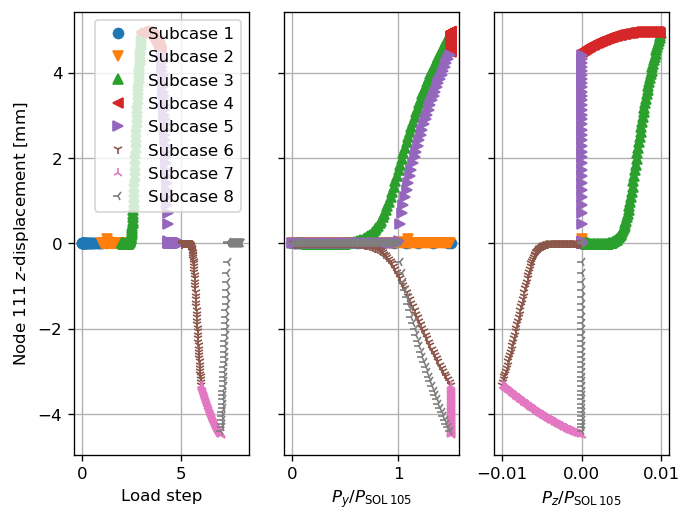

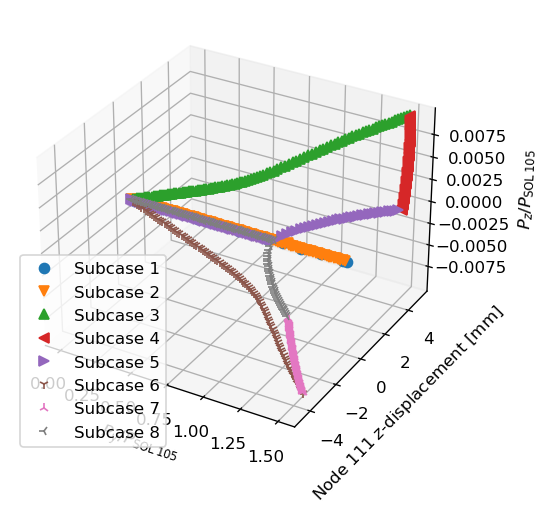

In [374]:
from matplotlib.lines import Line2D  # module including the list of all markers available in matplotlib

markers = list(Line2D.markers.keys())[2:]  # store list of matplotlib markers

# Define function to plot 2D equilibrium diagram for each subcase
def plot_2d_equilibrium_diagram(disp, steps, loads, node_id):
    _, axs = plt.subplots(nrows=1, ncols=3, sharey='all')  # create figure with 3 subplots
    for id in range(1, subcase_id + 1):  # iterate over subcases
        vertical_displacement = disp[id][:, 2]  # save displacement along z
        axs[0].plot(steps[id], vertical_displacement, markers[id - 1], label=f'Subcase {id:d}')  # plot load step vs displacement
        axs[1].plot(-loads[id][:,1]/sol_105_buckling_load, vertical_displacement, markers[id - 1])  # plot applied load along y vs displacement, sign of load along y is inverted to show a positive load in the plot
        axs[2].plot(loads[id][:,2]/sol_105_buckling_load, vertical_displacement, markers[id - 1])  # plot applied load along z vs displacement
    axs[0].set_xlabel('Load step')
    axs[0].set_ylabel(f'Node {node_id:d} $z$-displacement [mm]')
    axs[0].grid(visible=True)
    axs[1].set_xlabel(r'$P_y/P_{\mathrm{SOL\/105}}$')
    axs[1].grid(visible=True)
    axs[2].set_xlabel(r'$P_z/P_{\mathrm{SOL\/105}}$')
    axs[2].grid(visible=True)
    axs[0].legend()
    plt.show()

# Define function to plot 3D equilibrium diagram for each subcase
def plot_3d_equilibrium_diagram(disp, loads, node_id):
    plt.figure()  # create figure
    ax_3d = plt.axes(projection='3d')  # create three-dimensional axes
    # Plot applied load along y vs displacement vs applied load along z
    for id in disp:  # iterate over subcases
        ax_3d.plot3D(-loads[id][:,1]/sol_105_buckling_load, disp[id][:,2], loads[id][:,2]/sol_105_buckling_load, markers[id - 1], label=f'Subcase {id:d}')  # sign of load along y is inverted to show a positive load in the plot
    ax_3d.set_xlabel(r'$P_y/P_{\mathrm{SOL\/105}}$')
    ax_3d.set_ylabel(f'Node {node_id:d} $z$-displacement [mm]')
    ax_3d.set_zlabel(r'$P_z/P_{\mathrm{SOL\/105}}$')
    ax_3d.legend()
    ax_3d.grid(visible=True)
    ax_3d.tick_params(axis='z', which='major', pad=8)
    ax_3d.zaxis.labelpad = 15
    plt.show()

# Read load and displacement history of all subcases
monitor_node_y = 640  # y-coordinate of monitor node [mm]
monitor_node_id = np.argmin(np.apply_along_axis(np.linalg.norm, 1, nodes_coordinates_array - np.array([w/2, monitor_node_y, h/2]))) + 1  # find the closest node to the prescribed position
load_steps, applied_loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2, displacement_node_id=monitor_node_id)  # read load displacement history

# Plot 2D and 3D equilibrium diagrams
plot_2d_equilibrium_diagram(displacements, load_steps, applied_loads, monitor_node_id)
plot_3d_equilibrium_diagram(displacements, applied_loads, monitor_node_id)

The results shown above demonstrate the presence of a supercritical pitchfork bifurcation.

## Reinforced box beam <a name="reinforced"></a>

***

### Setup of the numerical model <a name="reinforced-numerical-model"></a>

We consider the same geometry and material properties of the unreinforced box beam and reinforce the structure with a number of ribs based on a prescribed spacing of $w/2$.

In [375]:
ribs_spacing = w/2  # half of box beam's width
no_ribs = int(np.ceil(b/ribs_spacing)) + 1  # calculate number of ribs
ribs_y_locations = np.linspace(0, b, no_ribs)  # calculate y-coordinates of the ribs

# Print information to screen
np.set_printoptions(precision=0)
print(f'Number of ribs: {no_ribs:.0f}')
print(f'Ribs\' y-coordinate [mm]:')
print(ribs_y_locations)

Number of ribs: 10
Ribs' y-coordinate [mm]:
[   0.  500. 1000. 1500. 2000. 2500. 3000. 3500. 4000. 4500.]


We create a mesh of quadrilateral elements using the function `mesh_box_beam_with_pyvista` from the `box_beam_utils` module. We prescribe an edge length of 49 mm based on the results of a previous [mesh convergence study](08_Nonlinear_Buckling_of_a_Reinforced_Box_Beam.ipynb#mesh-convergence).

In [376]:
edge_length = 49  # [mm]
reinforced_box_beam_mesh = box_beam_utils.mesh_box_beam_with_pyvista(ribs_y_coordinates=ribs_y_locations, width=w, height=h, edge_length=edge_length)
nodes_coordinates_array = reinforced_box_beam_mesh.points
nodes_connectivity_matrix = reinforced_box_beam_mesh.faces.reshape(-1, 5)[:, 1:]

Successively we create a base `BDF` object where we define fixed boundary conditions at the root of the box beam.

In [377]:
reinforced_box_beam_bdf = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)
print(reinforced_box_beam_bdf.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 7154

bdf.elements: 0
  CQUAD4   : 7368

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


Let's apply the same compression force used for the unreinforced box beam. This time we use a RBE3 element to connect the nodes along the outer edges of the tip section to the node in the center as the rigidity of the tip is enforced by the presence of a physical rib.

In [378]:
# Find id of tip nodes
nodes_ids = np.arange(1, np.size(nodes_coordinates_array, 0) + 1)
tolerance = edge_length/100
outer_tip_nodes_ids = nodes_ids[(np.abs(nodes_coordinates_array[:, 1] - b) < tolerance) & ((nodes_coordinates_array[:, 0] < tolerance) | (np.abs(nodes_coordinates_array[:, 0] - w) < tolerance) | (np.abs(nodes_coordinates_array[:, 2] - h/2) < tolerance) | (np.abs(nodes_coordinates_array[:, 2] + h/2) < tolerance))]  # nodes along the edges of the tip section

# Add master node at the center of the tip section
tip_section_master_node_id = np.amax(nodes_ids) + 1
reinforced_box_beam_bdf.add_grid(tip_section_master_node_id, [w/2, b, 0.])

# Add RBE3 card to connect master node with outer nodes of the tip section
rbe3_eid = len(reinforced_box_beam_bdf.elements) + 1
reinforced_box_beam_bdf.add_rbe3(eid=rbe3_eid, refgrid=tip_section_master_node_id, refc='123456', weights=[1.]*len(outer_tip_nodes_ids), comps=['123456']*len(outer_tip_nodes_ids), Gijs=outer_tip_nodes_ids)

# Add FORCE card
pynastran_utils.add_unitary_force(bdf_object=reinforced_box_beam_bdf, nodes_ids=[tip_section_master_node_id], set_id=compression_force_set_id, direction_vector=compression_force_direction)

### Linear buckling analysis <a name="reinforced-linear-buckling"></a>

We use SOL 105 to calculate the linear buckling load and the corresponding buckling shape, so that we have a reference for the nonlinear analysis.

Nastran job reinforced_box_beam_linear_buckling.bdf completed
Wall time: 3.0 s


Buckling load: 105009 N
Buckling mode:


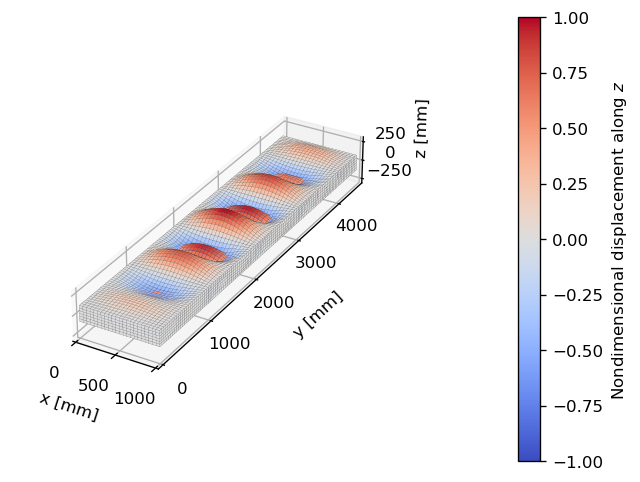

In [379]:
# Run SOL 105 and return OP2 object
input_name = 'reinforced_box_beam_linear_buckling'
sol_105_op2 = pynastran_utils.run_sol_105_buckling_analysis(bdf_object=reinforced_box_beam_bdf.__deepcopy__({}), static_load_set_id=compression_force_set_id, analysis_directory_path=analysis_directory_path, input_name=input_name, run_flag=False)  # we pass a deep copy of the BDF object to the function to be able to set up the nonlinear analysis later

# Print critical buckling load and plot mode
sol_105_buckling_load = sol_105_op2.eigenvectors[2].eigr
print(f'Buckling load: {sol_105_buckling_load:.0f} N')
print(f'Buckling mode:')
_, ax = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=2, displacement_component='tz', colormap='coolwarm')
set_ticks_and_labels_position(ax)
plt.show()

As expected, the buckling load of the reinforced configuration is larger than the one of the unreinforced configuration. Besides, the first buckling mode consists of nine alternating waves over each skin, corresponding to one for each rib bay, with a top-down symmetry.

### Nonlinear analysis <a name="reinforced-nonlinear-analysis"></a>

Also for the reinforced configuration we want to show the existence of a bifurcation in the equilibrium diagram. As a consequence, we set up the nonlinear analysis, the vertical force and the subcase sequence in the same way as done for the unreinforced configuration.

In [380]:
# Set up nonlinear analysis with full Newton method
pynastran_utils.set_up_newton_method(bdf_object=reinforced_box_beam_bdf, ninc=no_increments, eps_p=load_tolerance, eps_w=energy_tolerance)

# Add cards for arc-length method
reinforced_box_beam_bdf.add_nlparm(nlparm_id=arclength_nlparm_id, ninc=no_increments, kmethod='ITER', kstep=1, int_out='YES', eps_p=load_tolerance, eps_w=energy_tolerance)
reinforced_box_beam_bdf.add_nlpci(nlpci_id=arclength_nlparm_id, Type='CRIS', maxalr=1.1, desiter=5, mxinc=100)

# Add vertical force
top_skin_central_node_id = np.argmin(np.apply_along_axis(np.linalg.norm, 1, nodes_coordinates_array - np.array([w/2, b/2, h/2]))) + 1
pynastran_utils.add_unitary_force(bdf_object=reinforced_box_beam_bdf, nodes_ids=[top_skin_central_node_id], set_id=vertical_force_set_id, direction_vector=vertical_force_direction)

# Subcase 1
compression_load_magnitude = sol_105_buckling_load*1.5
reinforced_box_beam_bdf.add_load(sid=compression_load_set_id, scale=1., scale_factors=[compression_load_magnitude], load_ids=[compression_force_set_id])
subcase_id = 1
pynastran_utils.create_static_load_subcase(bdf_object=reinforced_box_beam_bdf, subcase_id=subcase_id, load_set_id=compression_load_set_id)
reinforced_box_beam_bdf.case_control_deck.subcases[subcase_id].add_integer_type('NLPARM', arclength_nlparm_id)

# Subcase 2
reinforced_box_beam_bdf.add_load(sid=zero_load_set_id, scale=1., scale_factors=[0.], load_ids=[compression_force_set_id])
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(bdf_object=reinforced_box_beam_bdf, subcase_id=subcase_id, load_set_id=zero_load_set_id)

# Subcase 3
vertical_load_magnitude = sol_105_buckling_load/100
reinforced_box_beam_bdf.add_load(sid=eccentric_compression_load_set_id, scale=1., scale_factors=[compression_load_magnitude, vertical_load_magnitude], load_ids=[compression_force_set_id, vertical_force_set_id])
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(bdf_object=reinforced_box_beam_bdf, subcase_id=subcase_id, load_set_id=eccentric_compression_load_set_id)

# Subcase 4
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(bdf_object=reinforced_box_beam_bdf, subcase_id=subcase_id, load_set_id=compression_load_set_id)

# Subcase 5
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(bdf_object=reinforced_box_beam_bdf, subcase_id=subcase_id, load_set_id=zero_load_set_id)

# Subcase 6
reinforced_box_beam_bdf.add_load(sid=opposite_eccentric_compression_load_set_id, scale=1., scale_factors=[compression_load_magnitude, -1*vertical_load_magnitude], load_ids=[compression_force_set_id, vertical_force_set_id])
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(bdf_object=reinforced_box_beam_bdf, subcase_id=subcase_id, load_set_id=opposite_eccentric_compression_load_set_id)

# Subcase 7
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(bdf_object=reinforced_box_beam_bdf, subcase_id=subcase_id, load_set_id=compression_load_set_id)

# Subcase 8
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(bdf_object=reinforced_box_beam_bdf, subcase_id=subcase_id, load_set_id=zero_load_set_id)

We run the analysis and once again plot the deformation at the end of each subcase.

Nastran job reinforced_box_beam_nonlinear_analysis.bdf completed
Wall time: 1569.0 s


Subcase 1


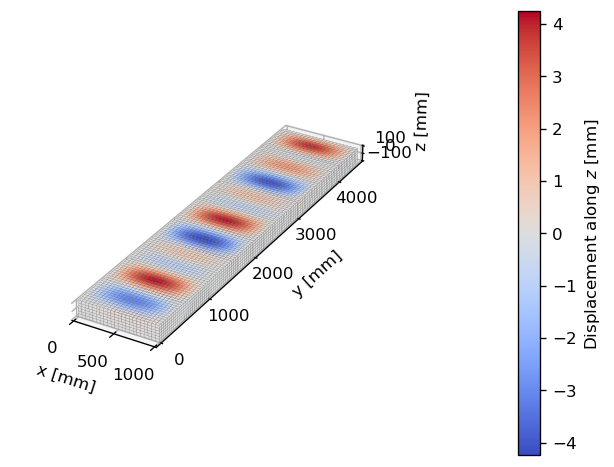

Subcase 2


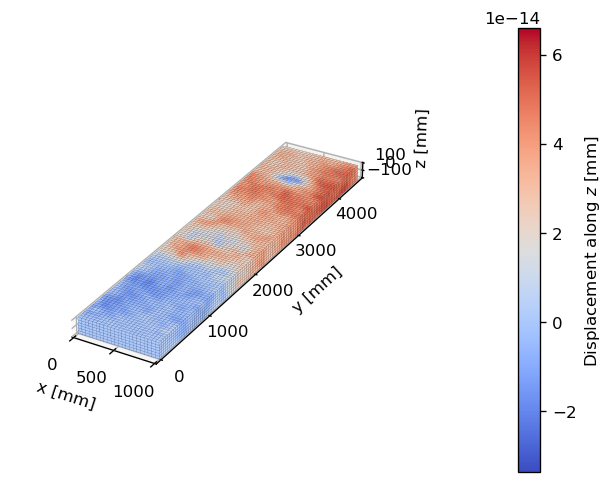

Subcase 3


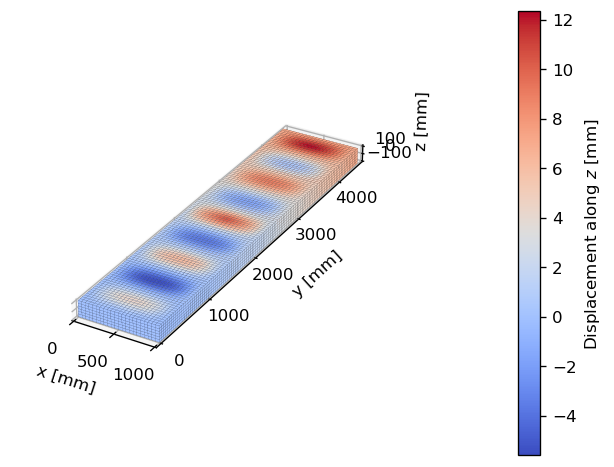

Subcase 4


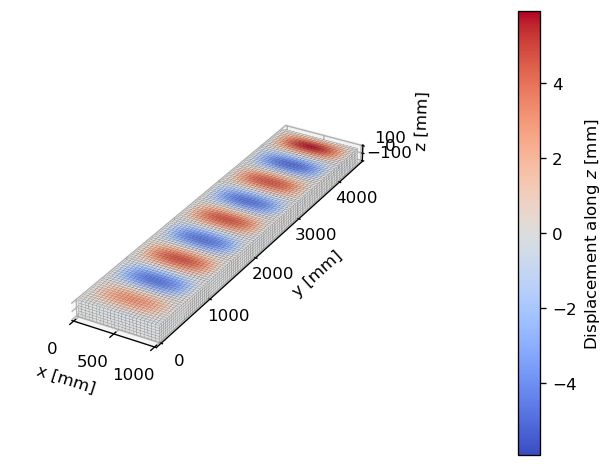

Subcase 5


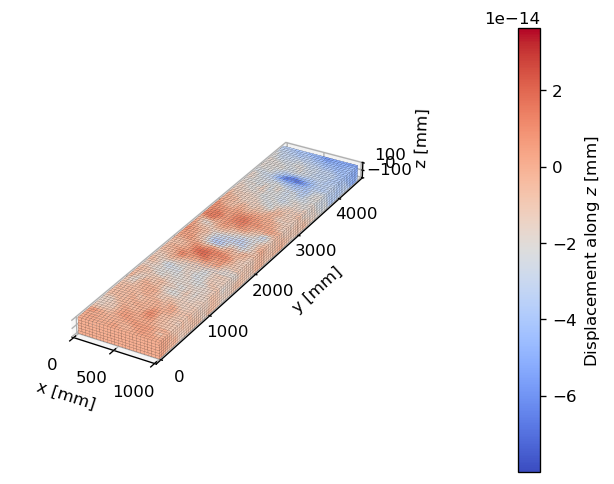

Subcase 6


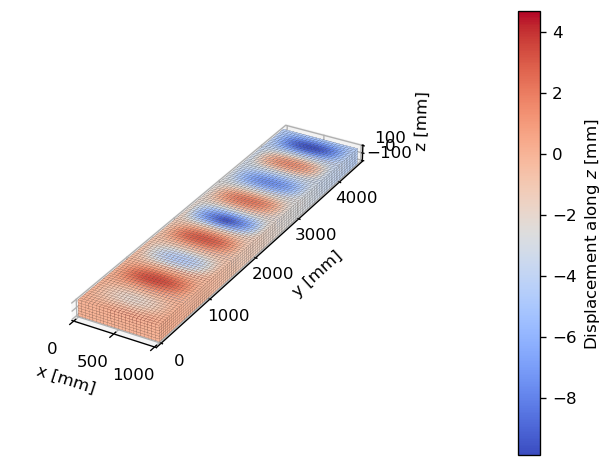

Subcase 7


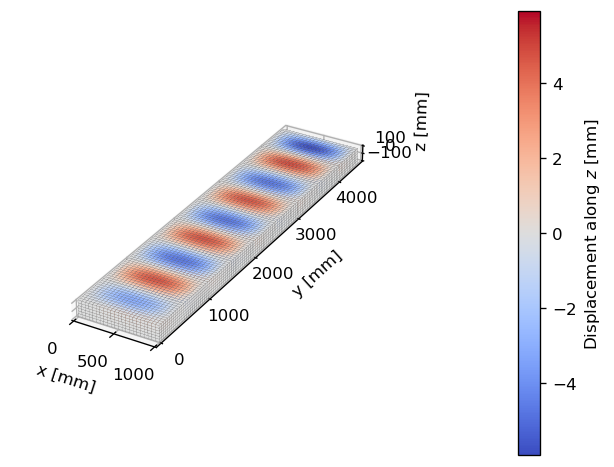

Subcase 8


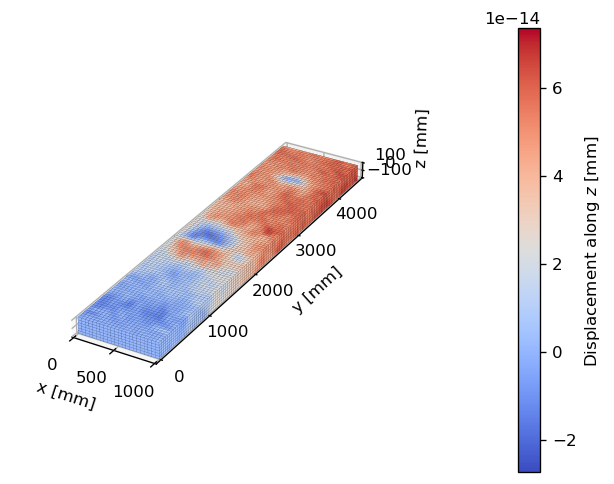

In [381]:
# Run analysis
input_name = 'reinforced_box_beam_nonlinear_analysis'
pynastran_utils.run_analysis(bdf_object=reinforced_box_beam_bdf, directory_path=analysis_directory_path, filename=input_name, run_flag=False)

# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_name + '.op2')
sol_106_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)

# Plot deformation
for i in range(1, subcase_id + 1):  # iterate through subcases
    print(f'\033[1mSubcase {i:.0f}')
    _, ax = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2, subcase_id=i, displacement_component='tz', colormap='coolwarm')  # plot final deformation
    set_ticks_and_labels_position(ax)
    plt.show()

Once again, we can observe a different displacement field at the end of subcases 1, 4 and 7 is different. This result suggests that also for the reinforced box beam there should be a bifurcation in the equilibrium diagram. Furthermore, the displacement field at the end of subcases 4 and 7 appears to be equal and opposite, similarly to what was observed previously.

Let's plot the 2D and 3D equilibrium diagram now. Also in this case we want to monitor the vertical displacement at the node that is approximately at the center of the first blob observed in subcases 4 and 7, so we change the queried $y$ coordinate accordingly ($y\approx320$ mm).

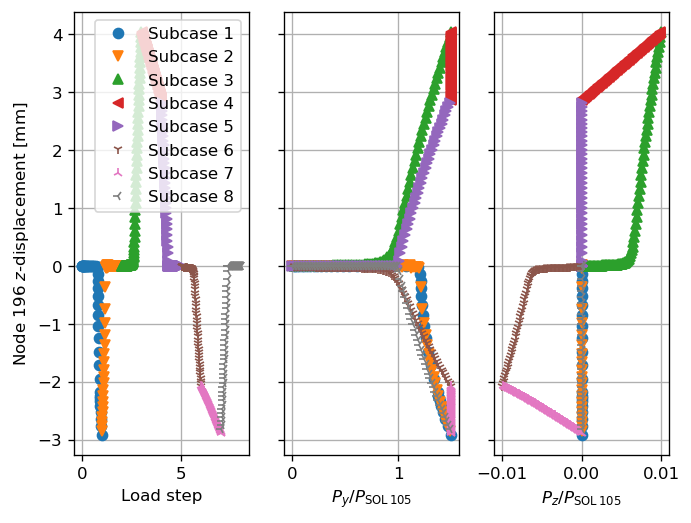

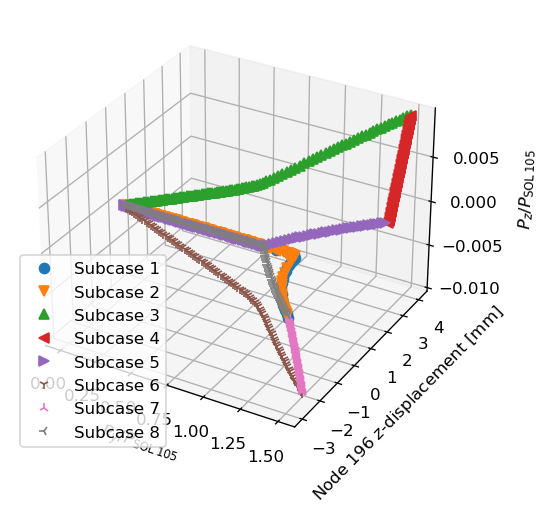

In [382]:
# Read load and displacement history of all subcases
monitor_node_y = 320  # y-coordinate of monitor node [mm]
monitor_node_id = np.argmin(np.apply_along_axis(np.linalg.norm, 1, nodes_coordinates_array - np.array([w/2, monitor_node_y, h/2]))) + 1  # find the closest node to the prescribed position
load_steps, applied_loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2, displacement_node_id=monitor_node_id)  # read load displacement history

# Plot 2D and 3D equilibrium diagrams
plot_2d_equilibrium_diagram(displacements, load_steps, applied_loads, monitor_node_id)
plot_3d_equilibrium_diagram(displacements, applied_loads, monitor_node_id)

The results show a supercritical pitchfork bifurcation at $P_y/P_{\text{SOL 105}}=1$. We can also observe what it looks like another bifurcation at about $P_y/P_{\text{SOL 105}}=1.2$, as the branch represented by the first subcase deviates from the zero-displacement line. The reason why this happens may be related to a number of factors, including the parameters of the arc-length method or its implementation in Nastran, and is difficult to ascertain without further investigation. However, since we were mainly interested in demonstrating the presence of a bifurcation at $P_y/P_{\text{SOL 105}}=1$, this is out of the scope of this notebook.


## Conclusions <a name="conclusions"></a>

***

In this notebook we have demonstrated the appearance of a supercritical pitchfork bifurcation when we apply a compression load rather than a bending load to the box beam. As a consequence, we can conclude that the asymmetry introduced by the bending load is responsible for the bifurcation break observed in our previous notebooks.